4
125


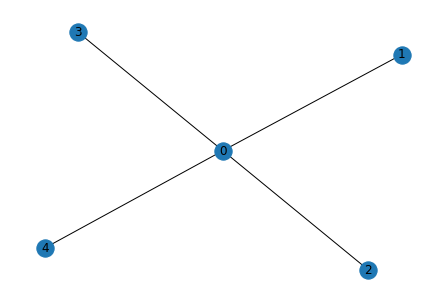

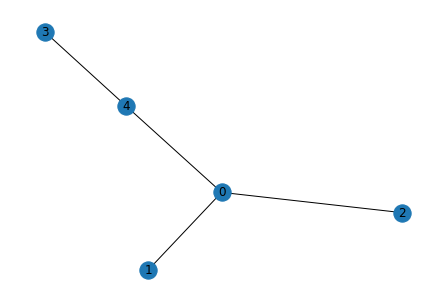

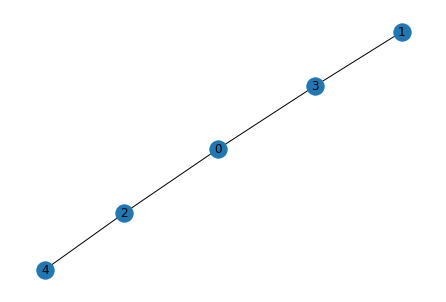

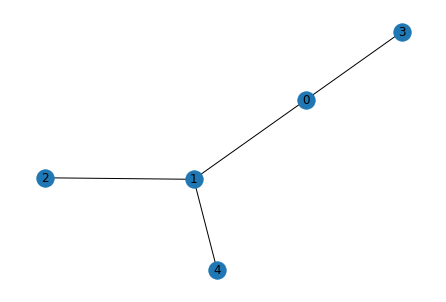

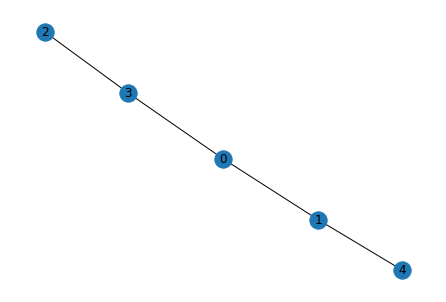

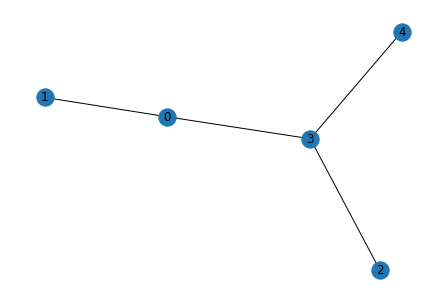

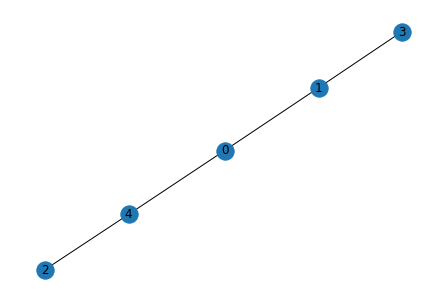

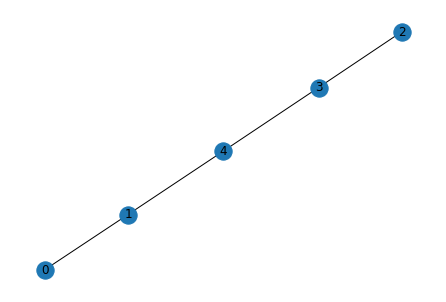

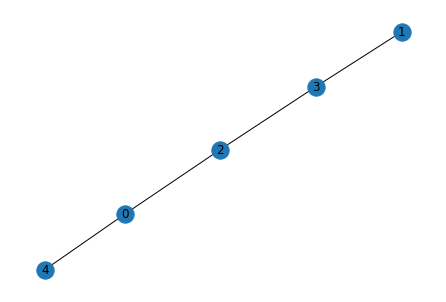

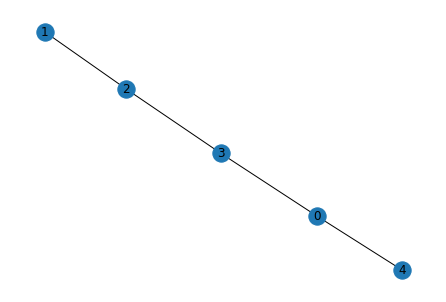

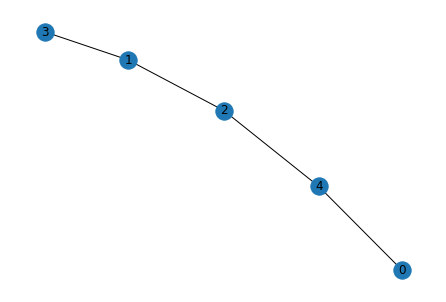

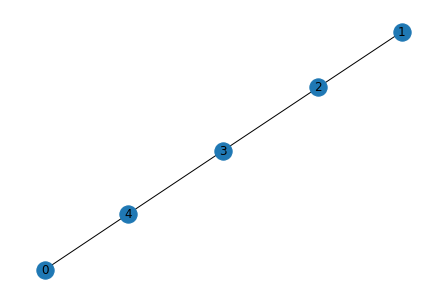

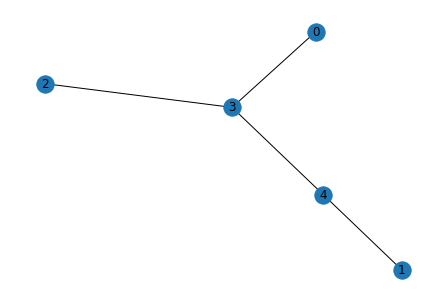

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms.tree.mst import SpanningTreeIterator

from itertools import product

from query_graphs.query_graphs import QueryGraphs

#tables = [0,1,2,3]
#joins = [(0, 1), (1, 2), (2, 3)]
#selectivity = {(0, 1): 1, (1, 2): 1, (2, 3): 1}
#cardinality = {0: 100, 1: 100, 2: 100, 3: 100}

query_graph = QueryGraphs().get_graph_7(5)

n_joins = len(query_graph.edges) - len(nx.cycle_basis(query_graph))
max_number_of_levels = n_joins
print(max_number_of_levels)
levels = range(max_number_of_levels)

cardinality = {}
for node in query_graph.nodes(data=True):
    cardinality[node[0]] = node[1]['cardinality']

selectivity = {}
for edge in query_graph.edges(data=True):
    selectivity[(edge[0], edge[1])] = edge[2]['selectivity']

#query_graph = nx.Graph()
#query_graph.add_nodes_from(tables)
#query_graph.add_edges_from(joins)

ego_graphs = []   

def shortest_path_between_edges(G, edge1, edge2):
    u1, v1 = edge1
    u2, v2 = edge2
    # Compute all shortest paths from nodes of edge1 to nodes of edge2
    paths = [nx.shortest_path(G, u, v) for u in (u1, v1) for v in (u2, v2)]
    # Return the shortest of these paths
    return len(min(paths, key=len))
        

def label_ego_graph_edges_max(G, edge):
    # Compute edge distance from the given edge to all the other edges and store the distance as an edge attribute
    for e in G.edges:
        if e[0] in edge and e[1] in edge:
            distance = 0
        else:
            distance = shortest_path_between_edges(G, e, edge)
            
        G[e[0]][e[1]]['level'] = distance
        G[e[1]][e[0]]['weight'] = 1
    return G

def label_ego_graph_edges_min(G, edge):
    # Compute edge distance from the given edge to all the other edges and store the distance as an edge attribute
    for e in G.edges:
        if e[0] in edge and e[1] in edge:
            distance = 0
        else:
            distance = shortest_path_between_edges(G, e, edge)
        G[e[0]][e[1]]['level'] = distance % 2
        G[e[1]][e[0]]['weight'] = 1
    return G



def edge_centric_ego_graph(G, edge, radius):
    ego_graph_left = nx.ego_graph(G, edge[0], radius=radius)
    ego_graph_right = nx.ego_graph(G, edge[1], radius=radius)
    ego_graph = nx.compose(ego_graph_left, ego_graph_right)
    
    if len(ego_graph.edges) == 0:
        ego_graph = nx.Graph()
        ego_graph.add_edges_from([edge])
    
    ego_graph1 = ego_graph.copy()
    ego_graph2 = ego_graph.copy()
    ego_graph_max = label_ego_graph_edges_max(ego_graph1, edge)
    ego_graph_min = label_ego_graph_edges_min(ego_graph2, edge)
    return ego_graph_max, ego_graph_min


def validate_spanning_tree(G):
    # Check that two joins with the same level are not adjacent: 
    # we cannot perform joins sharing a table in parallel
    for edge in G.edges:
        for neighbor in G.neighbors(edge[0]):
            if neighbor != edge[1]:
                if G[edge[0]][neighbor]['level'] == G[edge[0]][edge[1]]['level']:
                    return False
        for neighbor in G.neighbors(edge[1]):
            if neighbor != edge[0]:
                if G[edge[1]][neighbor]['level'] == G[edge[1]][edge[0]]['level']:
                    return False
    return True


def validate_spanning_tree_2(G):
    # Exclude tree if there are nodes with same level connected with lower level edges
    for u0, v0, data in G.edges(data=True):
        level_u = data.get('level', 0)
        
        if level_u == 0:
            continue
        
        for u1, v1, data1 in G.edges(data=True):
            if level_u == data1.get('level', 0):
            
                for path in nx.all_simple_paths(G, u0, u1):
                    path_levels = [G.edges[path[i], path[i+1]]['level'] for i in range(len(path) - 1)]
                    if any(level < level_u for level in path_levels):
                        return False
                    
                for path in nx.all_simple_paths(G, v0, u1):
                    path_levels = [G.edges[path[i], path[i+1]]['level'] for i in range(len(path) - 1)]
                    if any(level < level_u for level in path_levels):
                        return False
                    
                for path in nx.all_simple_paths(G, u0, v1):
                    path_levels = [G.edges[path[i], path[i+1]]['level'] for i in range(len(path) - 1)]
                    if any(level < level_u for level in path_levels):
                        return False
                    
                for path in nx.all_simple_paths(G, v0, v1):
                    path_levels = [G.edges[path[i], path[i+1]]['level'] for i in range(len(path) - 1)]
                    if any(level < level_u for level in path_levels):
                        return False
    return True


def validate_spanning_tree_3(G):
    # Exclude tree if there are edges with no level lower than the max level in the tree
    max_level = max([data.get('level') for u, v, data in G.edges(data=True)])
    levels_in_tree = set([data.get('level') for u, v, data in G.edges(data=True)])
    if set(range(max_level)) - levels_in_tree:
        return False
    return True


def spanning_trees_of_ego_graphs(ego_graphs):
    spanning_trees = []
    for ego_graph in ego_graphs:
        for stree in SpanningTreeIterator(ego_graph):
            #if validate_spanning_tree(stree): #and validate_spanning_tree_2(stree): #and validate_spanning_tree_3(stree):
                spanning_trees.append(stree)
            #if validate_spanning_tree(stree): #and validate_spanning_tree_2(stree): #and validate_spanning_tree_3(stree):
    return spanning_trees

import networkx.algorithms.isomorphism as iso
em = iso.numerical_edge_match("level", 1)

def draw_graphs_up_to_isomorphism(graphs):
    i = 0
    non_isomorphic_graphs = []
    for graph in graphs:
        for g in non_isomorphic_graphs:
            if nx.is_isomorphic(graph, g, edge_match=em):
                break
        else:
            non_isomorphic_graphs.append(graph)
    for graph in non_isomorphic_graphs:
        plt.figure(i)
        i += 1
        pos = nx.spring_layout(graph)
        nx.draw(graph, with_labels=True, pos=pos)
        nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'level'))
        
        
#i = 0
#for level in levels:
#    for join in query_graph.edges():
        #print("Level: %d, Join: %s" % (level, join))
#        ego_graph_max, ego_graph_min = edge_centric_ego_graph(query_graph, join, level)
#        if i % 10 == 0:
#            plt.figure(i)
#            pos = nx.spring_layout(ego_graph_min)
#            nx.draw(ego_graph_min, with_labels=True, pos=pos)
#            nx.draw_networkx_edge_labels(ego_graph_min, pos=pos, edge_labels=nx.get_edge_attributes(ego_graph_min, 'level'))
#        ego_graphs.append(ego_graph_max)
#        ego_graphs.append(ego_graph_min)
#        i += 1
        
#ego_graphs = spanning_trees_of_ego_graphs(ego_graphs)
#draw_graphs_up_to_isomorphism(ego_graphs)

i = 0
for stree in SpanningTreeIterator(query_graph):
    if i % 10 == 0:
            plt.figure(i)
            pos = nx.spring_layout(stree)
            nx.draw(stree, with_labels=True, pos=pos)
            nx.draw_networkx_edge_labels(stree, pos=pos, edge_labels=nx.get_edge_attributes(stree, 'level'))
    i += 1

print(i)

In [ ]:
def construct_variables(ego_graph):
    coefficient = 0
    variables = []
    for edge in ego_graph.edges:
        level = ego_graph[edge[0]][edge[1]]['level']
        variables.append((edge[0], edge[1], level))
        coefficient += cardinality[edge[0]] * cardinality[edge[1]] * selectivity[edge]
    
    cycle_variables = {}
    
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            var1 = variables[i]
            var2 = variables[j]
            
            if var1[2] == var2[2]:
                
                if var1[0] == var2[0]:
                    overlap = (var1[0], var1[2])    
                elif var1[1] == var2[1]:
                    overlap = (var1[1], var1[2])
                elif var1[0] == var2[1]:
                    overlap = (var1[0], var1[2])
                elif var1[1] == var2[0]:
                    overlap = (var1[1], var1[2])
                else:
                    continue
                    
                if overlap not in cycle_variables:
                    cycle_variables[overlap] = [var1, var2]
                else:
                    cycle_variables[overlap].append(var1)
                    cycle_variables[overlap].append(var2)
    
    new_variables = set()
    
    product_lists = [[x for x in cycle_variables[key]] for key in cycle_variables]
    combinations = list(product(*product_lists))
    for combination in combinations:
        xs = [x for x in variables if x not in combination]
        if len(xs) < 3:
            print("Here", xs)
        new_variables.add(tuple(xs))
        
    if len(cycle_variables) == 0:
        new_variables = set(variables)
    
    removed_vars = set()
    for var in new_variables:
        if len(var) > max_number_of_levels:
            removed_vars.add(var)
            
    new_variables = new_variables - removed_vars
    
    return new_variables, coefficient  

model = []

for ego_graph in ego_graphs:
    model.append(construct_variables(ego_graph))

for x in model:
    print(x)